In [62]:
import config
import numpy as np
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup
import folium
import urllib
import regex as re
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import plotly.express as px

# Retail Opportunity Inference from Nearby Cities
The purpose of this analysis is to determine new retail that should open the Church Hill neighborhood of Richmond, VA.  First we will broadly characterize Church Hill by grouping it with other neighborhoods with similar retail.  We can gather retail data on all the neighborhoods of Richmond and seven other nearby cities and perform machine learning clustering.  Once we have clusters of neighborhoods which have similar retail, we will deduce by elimination the categories missing from Church Hill but found in high frequency within its cluster.  

## 1 Data Collection

### 1.1 Geographic Data Collection using Google Geocoder
We start by collecting a list of neighborhoods and their latitude, longitude coordinates.  I've decided to look at all the neighborhoods of Baltimore, Charlotte, Charlottesville, Norfolk, Raleigh, Richmond, Virginia Beach, and Washington, DC.

In [53]:
#An empty dataframe to collect the neighborhood data.
neigh_df=pd.DataFrame(columns=['Neighborhood','City','State','Neighborhood Latitude','Neighborhood Longitude'])

In [54]:
#A function to plot the neighborhoods on a map.
def map_neigh(city,zoom, radius):
    lat_center = neigh_df.loc[neigh_df.City==city,'Neighborhood Latitude'].mean()
    lng_center = neigh_df.loc[neigh_df.City==city,'Neighborhood Longitude'].mean()

    f = folium.Figure(width=650, height=450)
    city_map = folium.Map(location=[lat_center,lng_center], zoom_start=zoom).add_to(f)

    # add markers to map
    for x,y, name in zip(neigh_df.loc[neigh_df.City==city,'Neighborhood Latitude'],neigh_df.loc[neigh_df.City==city,'Neighborhood Longitude'],neigh_df.loc[neigh_df.City==city,'Neighborhood']):
        label = '{}'.format(name)
        label = folium.Popup(label, parse_html=True)
        folium.Circle(
            [x,y],
            radius=radius,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(city_map)  

    return city_map

#### 1.1.1 Acquire Baltimore, MD neighborhood data

In [55]:
#Scrape wikipedia to generate a list of baltimore neighborhood names
bmd_page = requests.get('https://en.wikipedia.org/wiki/List_of_Baltimore_neighborhoods').text
bmd_soup = BeautifulSoup(bmd_page,'html.parser')
bmd_neigh=[]
neigh_search = bmd_soup.find_all('li')
for x in neigh_search[14:312]:
    name= re.sub(r"((|, | )\([^(]*|(|, | )\[[^(]*)", "", x.text)
    if name not in bmd_neigh:
        bmd_neigh.append(name)
bmd_neigh[261]='West Federal Hill'

#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in bmd_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Baltimore, MD"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Baltimore','State':'MD','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

No lat long data found for  West Hill Square


In [56]:
map_neigh('Baltimore',zoom=11,radius=250)

In [57]:
neigh_df.loc[neigh_df.City=='Baltimore','Radius']=250

#### 1.1.2 Acquire Charlotte, NC neighborhood data

In [58]:
#Scrape wikipedia to generate a list of Charlotte neighborhood names
cnc_page = requests.get('https://en.wikipedia.org/wiki/Category:Neighborhoods_in_Charlotte,_North_Carolina').text
cnc_soup = BeautifulSoup(cnc_page,'html.parser')
cnc_neigh=[]
neigh_search = cnc_soup.find_all('li')
for x in neigh_search[1:34]:
    name= re.sub(r"((|, | )\([^(]*|(|, | )\[[^(]*)", "", x.text)
    if name not in cnc_neigh:
        cnc_neigh.append(name)
        
#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in cnc_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Charlotte, NC"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Charlotte','State':'NC','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

In [59]:
map_neigh('Charlotte',zoom=10,radius=700)

In [60]:
neigh_df.loc[neigh_df.City=='Charlotte','Radius']=700

#### 1.1.3 Acquire Charlottesville, VA neighborhood data

In [61]:
#Scrape wikipedia to generate a list of charlottesville neighborhood names
cva_page = requests.get('https://www.cvillepedia.org/List_of_Charlottesville_neighborhoods').text
cva_soup = BeautifulSoup(cva_page,'html.parser')
cva_neigh=[]
neigh_search = cva_soup.find_all('li')
for x in neigh_search[5:23]:
    name= re.sub(r"((|, | )\([^(]*|(|, | )\[[^(]*)", "", x.text)
    if name not in cva_neigh:
        cva_neigh.append(name)

#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in cva_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Charlottesville, VA"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Charlottesville','State':'VA','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

In [62]:
map_neigh('Charlottesville',zoom=12,radius=400)

In [63]:
neigh_df.loc[neigh_df.City=='Charlottesville','Radius']=400

#### 1.1.4 Acquire Norfolk, VA neighborhood data

In [64]:
#Scrape wikipedia to generate a list of norfolk neighborhood names
norva_page = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Norfolk,_Virginia').text
norva_soup = BeautifulSoup(norva_page,'html.parser')
norva_neigh=[]
neigh_search = norva_soup.find_all('li')
for x in neigh_search[0:49]:
    norva_neigh.append(x.text)
norva_neigh[19]='Huntersville'
norva_neigh[3]='Bowling Green'

#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in norva_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Norfolk, VA"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Norfolk','State':'VA','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name) 

In [65]:
map_neigh('Norfolk',zoom=11,radius=400)

In [66]:
neigh_df.loc[neigh_df.City=='Norfolk','Radius']=400

#### 1.1.5 Acquire Raleigh, NC neighborhood data

In [67]:
#Scrape wikipedia to generate a list of raleigh neighborhood names
rgh_page = requests.get('https://en.wikipedia.org/wiki/Raleigh,_North_Carolina_neighborhoods').text
rgh_soup = BeautifulSoup(rgh_page,'html.parser')
rgh_neigh=[]
neigh_search = rgh_soup.find_all('li')
for x in neigh_search[4:109]:
    rgh_neigh.append(x.text)
    
#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in rgh_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Raleigh, NC"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Raleigh','State':'NC','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

No lat long data found for  Westlake


In [68]:
map_neigh('Raleigh',zoom=11,radius=400)

In [69]:
neigh_df.loc[neigh_df.City=='Raleigh','Radius']=400

#### 1.1.6 Acquire Richmond, VA neighborhood data.

In [70]:
#Scrape wikipedia to generate a list of rva neighborhood names
rva_page = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Richmond,_Virginia').text
rva_soup = BeautifulSoup(rva_page,'html.parser')
rva_neigh=[]
neigh_search = rva_soup.find_all('li')
for x in neigh_search[7:112]:
    rva_neigh.append(x.text)

#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in rva_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Richmond, VA"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Richmond','State':'VA','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

In [71]:
map_neigh('Richmond',zoom=11,radius=400)

In [72]:
neigh_df.loc[neigh_df.City=='Richmond','Radius']=400

#### 1.1.7 Acquire Virginia Beach, VA neighborhood data

In [73]:
#Here is the list of Virginia Beach neighborhoods
vab_neigh=['Alanton', 'Aragona Village', 'Bay Colony', 'Bayside', 'Cape Henry', 'Chesapeake Beach', 
               'Croatan Beach', 'Great Neck Point', 'Green Run', 'Kempsville', 'Lago Mar', 'Larkspur', 
               'London Bridge', 'Lynnhaven', 'Newtown', 'The North End', 'Oceana', 'Ocean Park', 'Pembroke Manor',
               'Princess Anne', 'Pungo', 'Red Mill Commons', 'Sandbridge', 'Thalia', 'Thoroughgood']

#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in vab_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Virginia Beach, VA"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Virginia Beach','State':'VA','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

In [74]:
map_neigh('Virginia Beach',zoom=10,radius=800)

In [75]:
neigh_df.loc[neigh_df.City=='Virginia Beach','Radius']=800

#### 1.1.8 Acquire Washington, DC neighborhood data

In [76]:
#Scrape wikipedia to generate a list of washington, dc neighborhood names
wdc_page = requests.get('https://en.wikipedia.org/wiki/Neighborhoods_in_Washington,_D.C.').text
wdc_soup = BeautifulSoup(wdc_page,'html.parser')
wdc_neigh=[]
neigh_search = wdc_soup.find_all('li')
for x in neigh_search[11:153]:
    name= re.sub(r"(| )\([^()]*\)", "", x.text)
    if name not in wdc_neigh:
        wdc_neigh.append(name)
        
#Geocode the latitude and longitude of each neighborhood and append to the neigh_df
for name in wdc_neigh:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(urllib.parse.quote(name+", Washington, DC"),config.google_api_key)
    results = requests.get(url).json()
    try:
        lat=results['results'][0]['geometry']['location']['lat']
        lng= results['results'][0]['geometry']['location']['lng']
        neigh_df=neigh_df.append({'Neighborhood':name,'City':'Washington','State':'DC','Neighborhood Latitude':lat,'Neighborhood Longitude':lng},ignore_index=True)
    except:
        print('No lat long data found for ',name)

In [77]:
map_neigh('Washington',zoom=11,radius=250)

In [78]:
neigh_df.loc[neigh_df.City=='Washington','Radius']=250

In [79]:
#Save to csv file 
neigh_df.to_csv('neigh_df.csv',index=False)

In [28]:
neigh_df.shape

(747, 6)

We've collected 747 total neighborhoods from the eight cities we chose.

### 1.2 Retail Data Collection from Foursquare

Now we collect all retail venues found within a radius of each neighborhood collected above.  We chose the radius based on the map views above.

In [15]:
neigh_df=pd.read_csv('neigh_df.csv')

In [ ]:
#A function to retrieve nearby retail venue data with the foursquare api.
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

def getNearbyVenues(df):
    
    venues_list=[]
    for neigh, city, state, lat, lng , radius in zip(df['Neighborhood'], df['City'],df['State'], df['Neighborhood Latitude'], df['Neighborhood Longitude'], df['Radius']):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            config.foursquare_id, 
            config.foursquare_secret, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            neigh, 
            city,
            state,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        print(neigh, end='\r')
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'City',
                  'State',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
#Collect all the retail locations by executing the function defined above.
venues_df=getNearbyVenues(neigh_df)

In [279]:
venues_df

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arts District,Richmond,VA,37.543453,-77.438963,Pop's Market on Grace,37.542080,-77.438512,Café
1,Arts District,Richmond,VA,37.543453,-77.438963,Secret Sandwich Society,37.541787,-77.438228,Sandwich Place
2,Arts District,Richmond,VA,37.543453,-77.438963,Perly's,37.543848,-77.441436,Deli / Bodega
3,Arts District,Richmond,VA,37.543453,-77.438963,Rappahannock Restaurant,37.542810,-77.439207,Seafood Restaurant
4,Arts District,Richmond,VA,37.543453,-77.438963,Salt & Forge,37.545206,-77.440183,Sandwich Place
...,...,...,...,...,...,...,...,...,...
5735,Starmount,Charlotte,NC,35.141693,-80.868220,Park South Station Pool and Fitness Club,35.145354,-80.864310,Club House
5736,Starmount,Charlotte,NC,35.141693,-80.868220,On The Go Mart,35.143072,-80.875201,Gas Station
5737,Stonehaven,Charlotte,NC,35.155497,-80.763010,"Quality Grill Parts, LLC",35.156302,-80.761389,Business Service
5738,Stonehaven,Charlotte,NC,35.155497,-80.763010,Betty Boos Treats,35.155218,-80.756179,Bakery


We've collected data on 5740 venues.

In [132]:
#Save venue data to csv file
venues_df.to_csv('venues_df.csv',index=False)

## 2 Data Preparation

In [137]:
#Read neighborhood and venue data from csv files
venues_df=pd.read_csv('venues_df.csv')
venues_df.shape

(5740, 9)

In [138]:
#Remove catergories called neighborhood
venues_df=venues_df[venues_df['Venue Category']!='Neighborhood'] 
venues_df.shape

(5732, 9)

This removed 8 retail venues whose category was Neighborhood.

### 2.1 Count the number of retail locations in each neighborhood

In [139]:
#Make a column venue count which counts the number of venues in each neighborhood
neigh_df = venues_df.groupby(['Neighborhood','City','State','Neighborhood Latitude','Neighborhood Longitude'],as_index=False)['Venue'].count()
neigh_df.columns = ['Neighborhood','City','State','Neighborhood Latitude','Neighborhood Longitude','Neighborhood Venue Count']
neigh_df

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Neighborhood Venue Count
0,10th & Page,Charlottesville,VA,38.035116,-78.493400,14
1,Abell,Baltimore,MD,39.324474,-76.610944,4
2,Adams Morgan,Washington,DC,38.921242,-77.043493,52
3,Alanton,Virginia Beach,VA,36.880667,-76.024684,5
4,Allendale,Baltimore,MD,39.291798,-76.675200,1
...,...,...,...,...,...,...
582,Woodmoor,Baltimore,MD,39.338440,-76.733028,1
583,Woodridge,Washington,DC,38.933000,-76.968034,2
584,Woolen Mills,Charlottesville,VA,38.020366,-78.456190,5
585,Wyman Park,Baltimore,MD,39.330870,-76.627553,22


We see that only 587 of the 747 neighborhoods have at least one retail location on record.  

In [97]:
neigh_df.loc[neigh_df.Neighborhood=='Church Hill']

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Neighborhood Venue Count
102,Church Hill,Richmond,VA,37.53284,-77.416252,15


We also see that Church Hill has 15 retail locations on record.  Let's make a histogram of the venue counts of the 587 remaining neighborhoods.

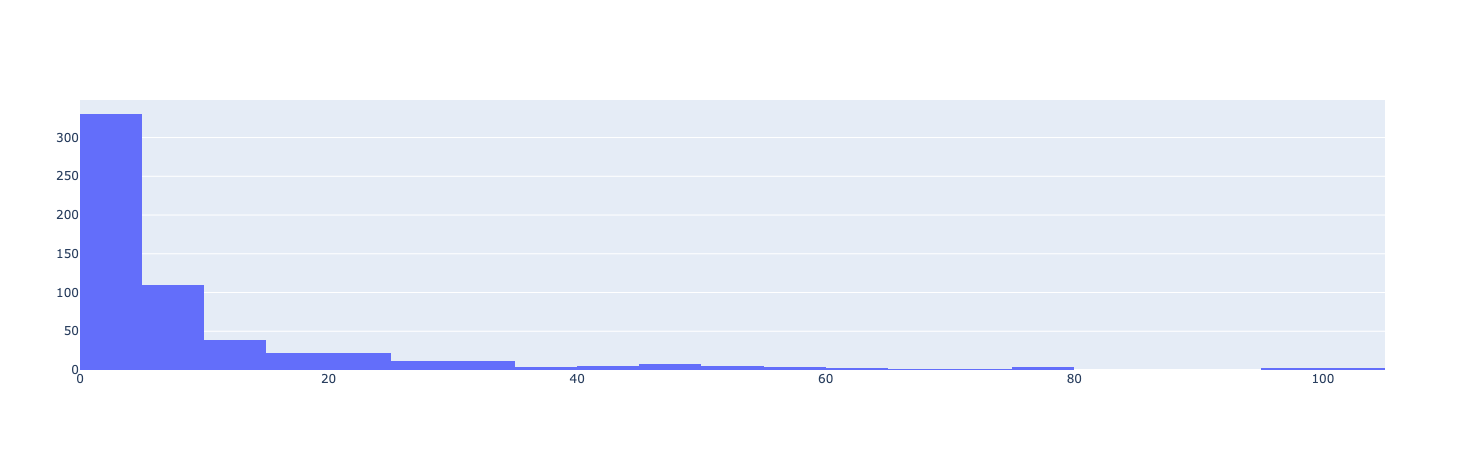

In [98]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=neigh_df['Neighborhood Venue Count'],xbins=dict( #
        start=0,
        end=105,
        size=5)))
fig.show()

There are 480 neighborhoods with less than 15 retail locations.  Since we are clustering to find similar neighborhoods, it would make sense to ignore these 480 neighborhoods with less than 15 retail locations.  SO we have 107 neighborhoods remaining that we can cluster.

### 2.2 Remove Neighborhoods with minimal retail

In [140]:
#add the venue count column to the venues_df
venues_df=venues_df.merge(neigh_df,on=['Neighborhood','City','State','Neighborhood Latitude','Neighborhood Longitude'])
#Remove neighborhoods with less than 15 retail venues
venues_df = venues_df[(venues_df['Neighborhood Venue Count']>=15) & (venues_df['Neighborhood Venue Count']<=30) ]
venues_df

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighborhood Venue Count
0,Arts District,Richmond,VA,37.543453,-77.438963,Pop's Market on Grace,37.542080,-77.438512,Café,23
1,Arts District,Richmond,VA,37.543453,-77.438963,Secret Sandwich Society,37.541787,-77.438228,Sandwich Place,23
2,Arts District,Richmond,VA,37.543453,-77.438963,Perly's,37.543848,-77.441436,Deli / Bodega,23
3,Arts District,Richmond,VA,37.543453,-77.438963,Rappahannock Restaurant,37.542810,-77.439207,Seafood Restaurant,23
4,Arts District,Richmond,VA,37.543453,-77.438963,Salt & Forge,37.545206,-77.440183,Sandwich Place,23
...,...,...,...,...,...,...,...,...,...,...
5540,Sedgefield,Charlotte,NC,35.195794,-80.862686,Bank Of America ATM,35.199249,-80.867456,ATM,15
5541,Sedgefield,Charlotte,NC,35.195794,-80.862686,Southend Smokes,35.197174,-80.868896,Smoke Shop,15
5542,Sedgefield,Charlotte,NC,35.195794,-80.862686,Belle Acres Golf & Country Club,35.197746,-80.868902,Golf Course,15
5543,Sedgefield,Charlotte,NC,35.195794,-80.862686,EZ Pawn,35.196770,-80.869713,Miscellaneous Shop,15


We've removed 1859 retail venues by removing all the neighborhoods with less than 15 retail venues.

### 2.3 Create feature (dummy) columns for each retail category

In [141]:
#Make dummy columns on the venues_df
venues_df=pd.get_dummies(venues_df, columns= ['Venue Category'], prefix="", prefix_sep="") 
#Take the mean of each dummy column grouped by neighborhood to get the retail category frequency (percent)
neigh_df=venues_df.groupby(['Neighborhood','City','State','Neighborhood Latitude','Neighborhood Longitude'],as_index=False).mean().drop(labels=['Venue Latitude','Venue Longitude'],axis=1)
neigh_df

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Neighborhood Venue Count,ATM,Accessories Store,Afghan Restaurant,American Restaurant,...,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Aragona Village,Virginia Beach,VA,36.858903,-76.152288,15,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Arts District,Richmond,VA,37.543453,-77.438963,23,0.000000,0.000000,0.000000,0.043478,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Bellevue,Richmond,VA,37.590832,-77.457554,15,0.000000,0.000000,0.000000,0.066667,...,0.000000,0.000000,0.000000,0.00,0.000000,0.066667,0.000000,0.000000,0.000000,0.066667
3,Bromo Arts District,Baltimore,MD,39.294943,-76.619813,22,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Cameron Village,Raleigh,NC,35.793762,-78.657603,22,0.000000,0.000000,0.000000,0.045455,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Canton,Baltimore,MD,39.282183,-76.576276,16,0.000000,0.000000,0.000000,0.062500,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Capitol Hill,Washington,DC,38.886043,-76.999525,20,0.000000,0.000000,0.000000,0.100000,...,0.000000,0.000000,0.000000,0.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Church Hill,Richmond,VA,37.532840,-77.416252,15,0.000000,0.000000,0.000000,0.066667,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,City Center,Richmond,VA,37.542916,-77.437926,22,0.000000,0.000000,0.000000,0.045455,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Cottage Road Park,Norfolk,VA,36.911389,-76.257500,18,0.000000,0.000000,0.000000,0.000000,...,0.055556,0.055556,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### 2.4 Scale the feature columns

In [122]:
from sklearn.preprocessing import StandardScaler

In [142]:
X = neigh_df.values[:,5:]
X = np.nan_to_num(X)
scaled_features = StandardScaler().fit_transform(X)
scaled_features

array([[-1.43378873, -0.18316284, -0.13130643, ..., -0.13130643,
        -0.18678748, -0.43910736],
       [ 0.3471278 , -0.18316284, -0.13130643, ..., -0.13130643,
        -0.18678748, -0.43910736],
       [-1.43378873, -0.18316284, -0.13130643, ..., -0.13130643,
        -0.18678748,  3.56059726],
       ...,
       [-0.54333047, -0.18316284, -0.13130643, ..., -0.13130643,
        -0.18678748,  2.71855418],
       [-0.54333047, -0.18316284, -0.13130643, ..., -0.13130643,
        -0.18678748, -0.43910736],
       [ 0.12451323, -0.18316284, -0.13130643, ..., -0.13130643,
        -0.18678748, -0.43910736]])

## 3 Training the K-Means Clustering Model

### 3.1 Find the best parameter k (number of clusters)
Remember we're clustering 107 neighborhoods.  I chose a minimum of three clusters because I don't want a simple split.  I chose a maximum of 40 clusters because I want a few clusters to have at least three neighborhoods.

In [143]:
from sklearn import metrics
kmin=3
kmax=40

#Define a kmeans model
kmeans = KMeans(init='k-means++',random_state=3)
#Define an empty list to save error values (we will use the silhouette coefficient)
inertia_list = []
silhouette_list = []
for k in range(kmin,kmax):
    kmeans.set_params(n_clusters=k)
    kmeans.fit(scaled_features)
    inertia_list.append(kmeans.inertia_)
    silhouette_list.append(metrics.silhouette_score(scaled_features, kmeans.labels_,metric="euclidean"))
df=pd.DataFrame({'k':range(kmin,kmax),'inertia':inertia_list,'silhouette':silhouette_list})

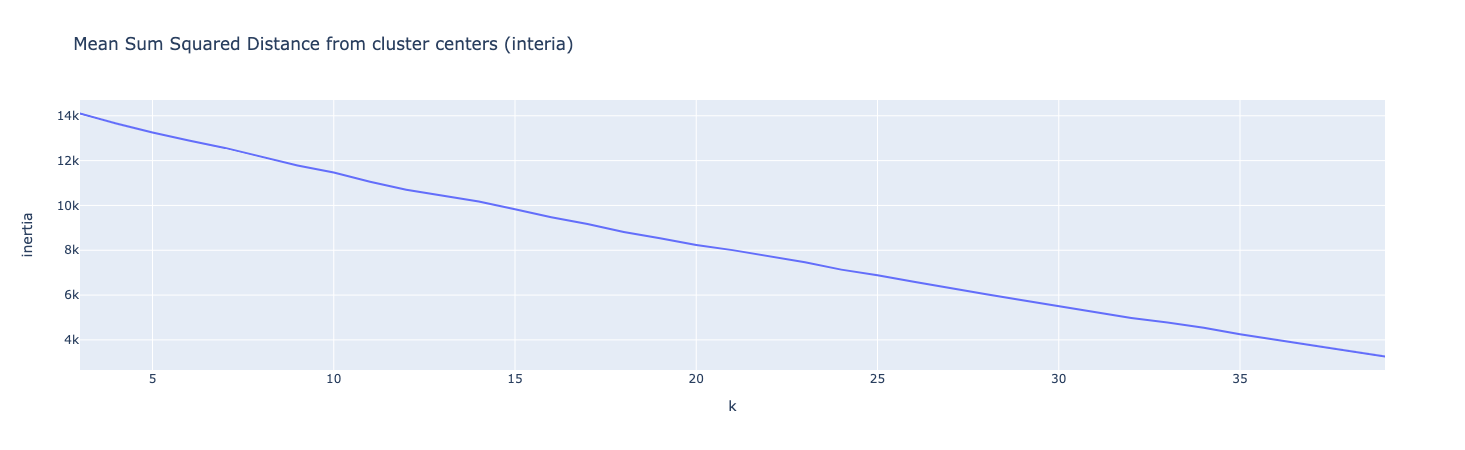

In [144]:
fig = px.line(df,x='k',y='inertia',title='Mean Sum Squared Distance from cluster centers (interia)')
fig.show()

We are hoping to find an elbow in this plot where the rate of decrease abruptly changes from rapid to gradual.  This would indicate diminishing returns on computation beyond a certain k value.  We don't see any sort of elbow.  We actually have a very smooth plot which may indicate that our clustering is not good.  Let's instead look at the mean silhouette coefficient.

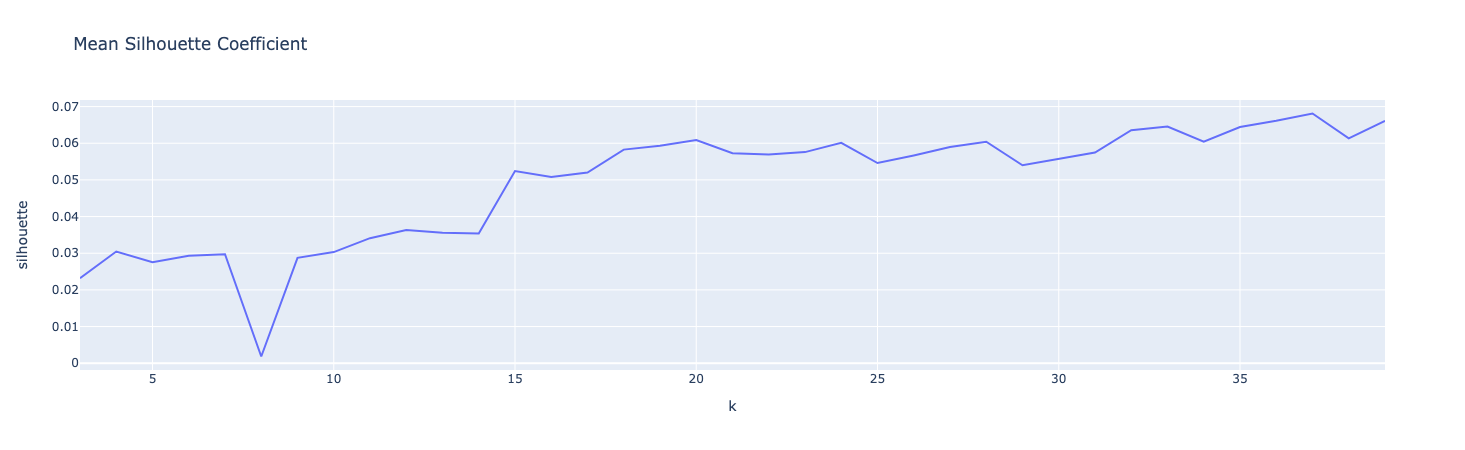

In [145]:
fig = px.line(df,x='k',y='silhouette',title='Mean Silhouette Coefficient')
fig.show()

The sihouette coefficient measures the distance of each sample to the center of its cluster in comparison to the distance to the nearest outside cluster.  It can range from -1 to 1 where 1 represents all dense and well seperated clusters.  The mean silhouette score gives us a rough idea of how well the entire model is clustering.  Based on our plot I'm going to choose k=18 clusters because this clustering gets the highest mean silhouette coefficient.

### 3.2 Fit the Model

In [146]:
#Define a kmeans model
kmeans = KMeans(init='k-means++',n_clusters=15,random_state=3)
#Fit the model
kmeans.fit(scaled_features)

KMeans(n_clusters=15, random_state=3)

In [147]:
#Add the cluster labels to the neigh_df
neigh_df.insert(loc=6,column='Cluster Label',value=kmeans.labels_)
neigh_df

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Neighborhood Venue Count,Cluster Label,ATM,Accessories Store,Afghan Restaurant,...,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Aragona Village,Virginia Beach,VA,36.858903,-76.152288,15,12,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Arts District,Richmond,VA,37.543453,-77.438963,23,1,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Bellevue,Richmond,VA,37.590832,-77.457554,15,8,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.066667,0.000000,0.000000,0.000000,0.066667
3,Bromo Arts District,Baltimore,MD,39.294943,-76.619813,22,1,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Cameron Village,Raleigh,NC,35.793762,-78.657603,22,8,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Canton,Baltimore,MD,39.282183,-76.576276,16,1,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Capitol Hill,Washington,DC,38.886043,-76.999525,20,1,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Church Hill,Richmond,VA,37.532840,-77.416252,15,12,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,City Center,Richmond,VA,37.542916,-77.437926,22,1,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Cottage Road Park,Norfolk,VA,36.911389,-76.257500,18,6,0.000000,0.000000,0.000000,...,0.055556,0.055556,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### 3.3 Observe the Clusters

In [148]:
neigh_df.loc[neigh_df.Neighborhood=='Church Hill']


,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Neighborhood Venue Count,Cluster Label,ATM,Accessories Store,Afghan Restaurant,...,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
7,Church Hill,Richmond,VA,37.53284,-77.416252,15,12,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [149]:
neigh_df.loc[neigh_df['Cluster Label']==12]

,Neighborhood,City,State,Neighborhood Latitude,Neighborhood Longitude,Neighborhood Venue Count,Cluster Label,ATM,Accessories Store,Afghan Restaurant,...,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Aragona Village,Virginia Beach,VA,36.858903,-76.152288,15,12,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
7,Church Hill,Richmond,VA,37.532840,-77.416252,15,12,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
10,Croatan Beach,Virginia Beach,VA,36.827958,-75.968639,23,12,0.000000,0.0,0.0,...,0.0,0.0,0.043478,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
21,Hi-Mount,Raleigh,NC,35.809907,-78.629234,15,12,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.066667,0.066667,0.0,0.0,0.0,0.0
36,North Ridge Country Club,Raleigh,NC,35.874371,-78.620667,21,12,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
38,Ocean Park,Virginia Beach,VA,36.909314,-76.101323,19,12,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
47,Sedgefield,Charlotte,NC,35.195794,-80.862686,15,12,0.066667,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
52,The North End,Virginia Beach,VA,36.893866,-75.986235,15,12,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
54,West End,Washington,DC,38.906805,-77.052129,23,12,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


Group by cluster label and take the mean of all the category columns.\
this will give an cluster_df containing cluster average frequency for each category.

In [150]:
cluster_df=neigh_df.groupby('Cluster Label')['Neighborhood'].count()
cluster_df

Cluster Label
0      1
1     21
2      1
3      1
4      2
5      1
6      1
7      1
8     15
9      1
10     2
11     1
12     9
13     1
14     1
Name: Neighborhood, dtype: int64

In [131]:
cluster_df=neigh_df.groupby('Cluster Label').mean()[neigh_df.columns[7:].to_list()]
cluster_df

,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
Cluster Label,,,,,,,,,,,,,,,,,,,,,
0,0.002415,0.000000,0.002646,0.020003,0.005051,0.002646,0.002525,0.000000,0.007466,0.002415,...,0.002415,0.005051,0.002415,0.000000,0.005291,0.002525,0.000000,0.000000,0.000000,0.004941
1,0.000000,0.009852,0.000000,0.033990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.009688,0.000000,0.000000,0.009524,0.009688,0.000000,0.004762,0.004926,0.009524
2,0.004762,0.000000,0.000000,0.036380,0.004762,0.000000,0.000000,0.004202,0.004464,0.008964,...,0.004202,0.000000,0.000000,0.000000,0.004762,0.009524,0.004202,0.000000,0.000000,0.004762
3,0.000000,0.000000,0.000000,0.056108,0.000000,0.000000,0.012991,0.008547,0.004444,0.000000,...,0.000000,0.004115,0.000000,0.000000,0.004274,0.004444,0.000000,0.000000,0.004444,0.017436
4,0.000000,0.000000,0.000000,0.046917,0.000000,0.000000,0.000000,0.004545,0.009330,0.000000,...,0.029532,0.009835,0.000000,0.004545,0.004545,0.000000,0.000000,0.000000,0.000000,0.004785


## 4 Anaysis and Determining New Retail for Church Hill

Define a function which takes a neighborhood in neigh_df and returns a 3 dataframes:\
1) corresponding cluster and its sorted columns with their frequencies \
2) neighborhood and and its sorted columns with their frequencies \
3) neighborhood's missing categories sorted by frequency of category minus frequency of neigborhood.\

Call this function for church hill

Call this function for some other neighborhoods

### 2.2 Find top 10 retail venue categories for each Neighborhood

Since we will want to be able to characterize each cluster and see what types of venues they have, let's write a function to sort the venues of any postal code area from most to least frequent.

In [163]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [166]:
temp_df=categories_df.drop(['Neighborhood Latitude','Neighborhood Longitude','Venue Count'],axis=1)

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City','Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
top_cats_by_neigh = pd.DataFrame(columns=columns)
top_cats_by_neigh[['City','Neighborhood']] = temp_df[['City','Neighborhood']]

for ind in np.arange(temp_df.shape[0]):
    top_cats_by_neigh.iloc[ind, 2:] = return_most_common_venues(temp_df.iloc[ind, :], num_top_venues)

top_cats_by_neigh.to_csv('top_cats_by_neigh.csv', index=False)
top_cats_by_neigh

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Baltimore, MD",Barre Circle,Ethiopian Restaurant,American Restaurant,Chinese Restaurant,Bar,Bakery,Coffee Shop,Bistro,Convenience Store,Restaurant,Bus Stop
1,"Baltimore, MD",Bromo Arts District,Chinese Restaurant,Lounge,Coffee Shop,Vegetarian / Vegan Restaurant,Noodle House,Seafood Restaurant,Taco Place,Library,Food Court,Dumpling Restaurant
2,"Baltimore, MD",Brooklyn,Chinese Restaurant,Fast Food Restaurant,Bus Stop,Pizza Place,Fish Market,Eye Doctor,Falafel Restaurant,Farmers Market,Filipino Restaurant,Film Studio
3,"Baltimore, MD",Canton,Pub,Bar,Irish Pub,Park,Café,Pharmacy,Dive Bar,Restaurant,Seafood Restaurant,Pizza Place
4,"Baltimore, MD",Cathedral Hill,Indian Restaurant,Wine Bar,Sandwich Place,Lounge,Gay Bar,Convenience Store,French Restaurant,Sushi Restaurant,Spa,Café
...,...,...,...,...,...,...,...,...,...,...,...,...
145,"Washington, DC",Southwest Federal Center,Food Truck,Coffee Shop,Donut Shop,French Restaurant,Deli / Bodega,Food & Drink Shop,Mexican Restaurant,Mediterranean Restaurant,Bike Rental / Bike Share,Bakery
146,"Washington, DC",Swampoodle,Gym,Performing Arts Venue,Sculpture Garden,Brewery,Indian Restaurant,Sporting Goods Shop,Office,Restaurant,Park,Coffee Shop
147,"Washington, DC",Truxton Circle,Art Gallery,Sandwich Place,Winery,Bus Line,Bar,Intersection,Cosmetics Shop,Seafood Restaurant,Bakery,Chinese Restaurant
148,"Washington, DC",U Street Corridor,Bar,Gay Bar,Ethiopian Restaurant,Pizza Place,Taco Place,New American Restaurant,Music Venue,Sandwich Place,Speakeasy,Thai Restaurant


In [59]:
top_cats_by_neigh.loc[top_cats_by_neigh.Neighborhood=='Church Hill']

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
87,"Richmond, VA",Church Hill,Bakery,New American Restaurant,Bridal Shop,BBQ Joint,Pub,Park,Sandwich Place,Southern / Soul Food Restaurant,Gift Shop,Thai Restaurant


## 3 Clustering

### 3.1 K-Means Clustering

In [171]:
categories_df=pd.read_csv('categories_df.csv')

# set number of clusters
kclusters = 26
cluster_df = caetgories_df.drop(['City','Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue Count'], axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df)

categories_df.insert(loc=5,column='Cluster Label',value=kmeans.labels_)
categories_df.to_csv('categories_df.csv',index=False)
categories_df

,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Count,Cluster Label,ATM,Accessories Store,Adult Boutique,Advertising Agency,...,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,"Baltimore, MD",Barre Circle,39.284705,-76.627914,13,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.076923,0.000000,0.0,0.0,0.0
1,"Baltimore, MD",Bromo Arts District,39.294943,-76.619813,22,16,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,"Baltimore, MD",Brooklyn,39.238196,-76.603722,75,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,"Baltimore, MD",Canton,39.282183,-76.576276,15,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,"Baltimore, MD",Cathedral Hill,39.299596,-76.617173,33,16,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.060606,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,"Washington, DC",Southwest Federal Center,38.885619,-77.021912,21,20,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
146,"Washington, DC",Swampoodle,38.903519,-77.002291,12,13,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
147,"Washington, DC",Truxton Circle,38.909973,-77.011825,11,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.090909,0.0,0.0,0.0
148,"Washington, DC",U Street Corridor,38.917001,-77.025272,45,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.022222,0.000000,0.000000,0.0,0.0,0.0


#### We can see that Church Hill, Richmond receives cluster label 16.

In [178]:
categories_df.loc[categories_df.Neighborhood=='Church Hill']

,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Count,Cluster Label,ATM,Accessories Store,Adult Boutique,Advertising Agency,...,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
87,"Richmond, VA",Church Hill,37.53284,-77.416252,16,16,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.2 Finding the top 25 retail venue categories for each neighborhood cluster

In [179]:
def return_most_common_venues_by_cluster(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [196]:
categories_df=pd.read_csv('categories_df.csv')
cluster_df = categories_df.drop(['Neighborhood Latitude','Neighborhood Longitude','Venue Count'],axis=1).groupby('Cluster Label').sum()
cluster_df=cluster_df.reset_index()
cluster_df.to_csv('cluster_df.csv',index=False)

num_top_venues = 25

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Label']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
top_cats_by_cluster = pd.DataFrame(columns=columns)
top_cats_by_cluster[['Cluster Label']] = cluster_df[['Cluster Label']]

for ind in np.arange(temp_df.shape[0]):
    top_cats_by_cluster.iloc[ind, 1:] = return_most_common_venues_by_cluster(cluster_df.iloc[ind, :], num_top_venues)

top_cats_by_cluster.to_csv('top_cats_by_cluster.csv', index=False)
top_cats_by_cluster

,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
0,0,Cycle Studio,Arcade,Theater,Spanish Restaurant,Park,Laundry Service,Coffee Shop,Beer Bar,Gay Bar,...,Farmers Market,Food Court,Food & Drink Shop,Food,Fast Food Restaurant,Filipino Restaurant,Film Studio,Financial or Legal Service,Exhibit,Fish Market
1,1,Bar,Coffee Shop,American Restaurant,Italian Restaurant,Cocktail Bar,Pizza Place,Music Venue,Mexican Restaurant,Southern / Soul Food Restaurant,...,Café,Seafood Restaurant,Bakery,Gym,Gay Bar,Taco Place,Sushi Restaurant,Nightclub,Gastropub,Sandwich Place
2,2,Chinese Restaurant,Fast Food Restaurant,Bus Stop,Pizza Place,Fish Market,Eye Doctor,Falafel Restaurant,Farmers Market,Filipino Restaurant,...,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Flower Shop,Event Space,Fountain,Ethiopian Restaurant,Deli / Bodega
3,3,Convenience Store,Sandwich Place,Bar,Pharmacy,Grocery Store,Discount Store,Video Store,Pizza Place,Supermarket,...,Gas Station,American Restaurant,Thai Restaurant,Intersection,Fast Food Restaurant,Art Gallery,Asian Restaurant,Bakery,Korean Restaurant,Arts & Crafts Store
4,4,Park,Art Gallery,Food Truck,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,...,Food,Food & Drink Shop,Food Court,Food Service,Football Stadium,Exhibit,Yoga Studio,French Restaurant,Ethiopian Restaurant,Deli / Bodega
5,5,Restaurant,American Restaurant,Bus Stop,Yoga Studio,Floating Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,...,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Eye Doctor,Ethiopian Restaurant,Event Space,French Restaurant
6,6,Clothing Store,Cosmetics Shop,American Restaurant,Italian Restaurant,Coffee Shop,Shoe Store,Pizza Place,Hotel,Mexican Restaurant,...,Jewelry Store,Women's Store,Plaza,Shopping Mall,Bakery,Steakhouse,Mediterranean Restaurant,Sporting Goods Shop,Gym,Fast Food Restaurant
7,7,Seafood Restaurant,Event Space,Boat or Ferry,Fish Market,Bar,Donut Shop,Food & Drink Shop,Food Court,Food,...,Film Studio,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Football Stadium,Eye Doctor,Yoga Studio,Exhibit,French Restaurant
8,8,Beach,Trail,Spa,Surf Spot,Historic Site,Yoga Studio,Fish Market,Falafel Restaurant,Farmers Market,...,Exhibit,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Eye Doctor,Ethiopian Restaurant,Event Space
9,9,Chinese Restaurant,Spa,Fish Market,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,...,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Floating Market,Event Space,Ethiopian Restaurant,Escape Room,Dance Studio


### 3.3 Finding the top 10 retail venue categories missing from each neighborhood
We need to modify the categories_df so each category frequency equals the corresponding frequency from the cluster_df minus the freq from the categories_df.

In [221]:
cluster16=categories_df[categories_df['Cluster Label']==16]
cluster16

,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Count,Cluster Label,ATM,Accessories Store,Adult Boutique,Advertising Agency,...,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
1,"Baltimore, MD",Bromo Arts District,39.294943,-76.619813,22,16,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,"Baltimore, MD",Cathedral Hill,39.299596,-76.617173,33,16,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.060606,0.000000,0.0,0.000000,0.000000,0.000000
6,"Baltimore, MD",Dolfield,39.335541,-76.674972,10,16,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
7,"Baltimore, MD",Downtown,39.292007,-76.616721,60,16,0.000000,0.0,0.000000,0.0,...,0.071429,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
9,"Baltimore, MD",Federal Hill,39.279304,-76.611666,24,16,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
18,"Baltimore, MD",Midtown-Belvedere,39.304755,-76.616721,34,16,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
19,"Baltimore, MD",Mount Vernon,39.299319,-76.613833,21,16,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.095238,0.000000,0.0,0.000000,0.000000,0.000000
21,"Baltimore, MD",Preston Gardens,39.293513,-76.613923,18,16,0.000000,0.0,0.000000,0.0,...,0.055556,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
24,"Baltimore, MD",South Balto.Imp.Comm./West Federal Hill,39.276312,-76.611404,50,16,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.020000,0.000000
27,"Baltimore, MD",West Pratt,39.285653,-76.636544,10,16,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.100000,0.000000,0.000000


In [222]:
cat16_rank=cluster16.groupby("Cluster Label").sum().iloc[:,3:].T
cat16_rank.columns=['Category Frequency']
cat16_rank=cat16_rank[cat16_rank['Category Frequency']>0]
cat16_rank.sort_values(by='Category Frequency',inplace=True,ascending=False)
cat16_rank_list=cat16_rank.index.to_list()
cat16_rank


,Category Frequency
Pizza Place,2.341457
Sandwich Place,1.706701
Chinese Restaurant,1.240079
American Restaurant,1.187954
Café,1.093852
...,...
College Theater,0.016667
Outdoor Supply Store,0.016667
Camera Store,0.016667
Comfort Food Restaurant,0.016667


In [223]:
church_hill_rank=cluster16[cluster16['Neighborhood']=='Church Hill'].iloc[:,6:].T
church_hill_rank.columns=['Category Frequency']
church_hill_rank=church_hill_rank[church_hill_rank['Category Frequency']>0]
church_hill_rank.sort_values(by='Category Frequency',inplace=True,ascending=False)
church_hill_rank_list=church_hill_rank.index.to_list()
church_hill_rank

,Category Frequency
Bakery,0.1875
New American Restaurant,0.1250
American Restaurant,0.0625
BBQ Joint,0.0625
Bridal Shop,0.0625
Deli / Bodega,0.0625
Gift Shop,0.0625
Historic Site,0.0625
Park,0.0625
Pub,0.0625


In [224]:
missing_from_church_hill=[]
for cat in cat16_rank_list:
    if cat not in church_hill_rank_list:
        missing_from_church_hill.append(cat)
missing_from_church_hill

['Pizza Place',
 'Chinese Restaurant',
 'Café',
 'Mexican Restaurant',
 'Coffee Shop',
 'Gym',
 'Convenience Store',
 'Restaurant',
 'Grocery Store',
 'Seafood Restaurant',
 'Bar',
 'Indian Restaurant',
 'Liquor Store',
 'Spa',
 'Salon / Barbershop',
 'Italian Restaurant',
 'Fast Food Restaurant',
 'Discount Store',
 'Pharmacy',
 'Sushi Restaurant',
 'Gym / Fitness Center',
 'Ice Cream Shop',
 'Burger Joint',
 'Shipping Store',
 'Yoga Studio',
 'Market',
 'French Restaurant',
 'Donut Shop',
 'Shopping Mall',
 'Lounge',
 'Breakfast Spot',
 'Furniture / Home Store',
 'Middle Eastern Restaurant',
 'Thrift / Vintage Store',
 'Supermarket',
 'Pet Store',
 'Beer Garden',
 'Bank',
 'Latin American Restaurant',
 'Vietnamese Restaurant',
 'Hookah Bar',
 'Mediterranean Restaurant',
 'Fried Chicken Joint',
 'Wine Bar',
 'Juice Bar',
 'Video Store',
 'Caribbean Restaurant',
 'Peruvian Restaurant',
 'Gas Station',
 'Bookstore',
 'Smoke Shop',
 'Arts & Crafts Store',
 'Brewery',
 'Intersection',
 'F